In [160]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as fn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [316]:
##Utils
def pil_to_tensor(img):
    """Converts the PIL img to a tensor usable for training"""
    img = ToTensor()(img)
    return img

def plot_latents(model, data, mode='ae', fig_size=(10, 10)):
    """
    Encodes images into latent space and produce a plot
    using the latent embeddings of th MNIST dataset.
    NOTE: Make sure the latent embeddings has only 2 dims. 
    Args:
        data : dataloader for images, labels.
        
    Returns:
        Plot in latent space
    """
    latents = []
    labels = []
    size = fig_size
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(projection='3d')
    
    for i, batch in enumerate(data):
        imgs, digits = batch 
        imgs = imgs.squeeze(1).reshape(-1, 28*28)
        if mode == 'ae':
            embeds, _ = model(imgs)
        if mode == 'vae':
            embeds, _,_,_ = model(imgs)
        embeds = embeds.detach().numpy().tolist()
        digits = digits.detach().numpy().tolist()
        latents.extend(embeds)
        labels.extend(digits)
    latents = np.asarray(latents)
    print(f"Labels:{len(labels)}, Data:{len(latents)}")
    plt.scatter(latents[:,1], latents[:,2], latents[:,0], c=labels, cmap='tab10')
    plt.colorbar()
    
def generate_latents(model, images, mode='ae'):
    """
    Encodes images into latent space.
    Args:
        images : tensors of shape (-1, 1, 28, 28)
    Returns:
        Reconstructed img
    """
    imgs = images.squeeze(1).reshape(-1, 28*28)
    if mode == 'ae':
        latents, reconstructed = model(imgs)
    if mode == 'vae':
        latents, reconstructed,_,_ = model(imgs)
    
    return imgs.detach().numpy(), reconstructed.detach().numpy()


In [249]:
##Dataset
class MNIST_Dataset(Dataset):
    """Custom MNIST Dataset"""
    def __init__(self, root_dir, set='Train', transforms=[], filter_labels = []):
        """
        Args:
            root_dir  : Root directory where MNIST is stored. If the directory 
                        doesn't exist, it will create a new directory and 
                        download the MNIST dataset.
            transforms: List of transforms to be applied.
        """
        self.set = set
        self.transforms = transforms
        if not os.path.exists(root_dir):
            download = True
        else:
            download = False
        if set == 'Train':
            self.mnist = datasets.MNIST(root=root_dir, download=download, train=True)  
            self.filter_set(filter_labels)
            indices = range(min(50000, int(0.9*len(self.mnist))))
            self.mnist = [self.mnist[i] for i in indices]
        
        if set == 'Valid':
            self.mnist = datasets.MNIST(root=root_dir, download=download, train=True)
            self.filter_set(filter_labels)
            ind_start = min(50000, int(0.9*len(self.mnist)))
            self.mnist = [self.mnist[i+ind_start] for i in range(len(self.mnist) - ind_start)]
                            
        if set == 'Test':
            self.mnist = datasets.MNIST(root=root_dir, download=download, train=False)
            self.filter_set(filter_labels)
           
        
    def filter_set(self, filter_labels):
        dataset = []
        if len(filter_labels) == 0:
            return
        for i, (img, label) in enumerate(self.mnist):
            if label in filter_labels:
                dataset.append((img, label))
        self.mnist = dataset
        
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        for i, transform in enumerate(self.transforms):
            img = transform(img)
        return img, label
            

## AutoEncoder

In [256]:
##AutoEncoders
class Encoder(nn.Module):
    """Encoder class for Auto-Encoder"""
    def __init__(self, embed_dim):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 512)
        self.linear2 = nn.Linear(512, embed_dim)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        """
        Takes input from MNIST dataset for toy example.
        Args:
            x is the input image in the shape of (batch, 28*28)

        Returns:
            An embedding vector tensor with shape (batch, self.embed_dim).
        """
        x = self.relu(self.linear1(x))
        encoded = self.sig(self.linear2(x))
        return encoded
    
class Decoder(nn.Module):
    """Decoder class for Auto-Encoder"""
    def __init__(self, embed_dim):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, 512)
        self.linear2 = nn.Linear(512, 28*28)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, embed):
        """
        Takes input the encoded vector.
        Args:
            embed is the input encoded embedding in the shape of (batch, self.embed_dim)

        Returns:
            A flattened tensor of the shape (batch, 28*28).
        """
        x = self.relu(self.linear1(embed))
        decoded = self.relu(self.linear2(x))
        return decoded
    
    
class AutoEncoder(nn.Module):
    """Aute Encoder class"""
    def __init__(self, embed_dim):
        super().__init__()
        self.encoder = Encoder(embed_dim)
        self.decoder = Decoder(embed_dim)

    def forward(self, x):
        embedding = self.encoder(x)
        reconstructed = self.decoder(embedding)
        return embedding, reconstructed

In [282]:
transforms = [pil_to_tensor]#, normalize]

train_dataset = MNIST_Dataset(root_dir="~/Anurag/MNIST", 
                              set='Train', 
                              transforms=transforms)

tr_dataloader = DataLoader(train_dataset, batch_size=128,
                           shuffle=True, num_workers=0)

val_dataset = MNIST_Dataset(root_dir="~/Anurag/MNIST", 
                              set='Valid', 
                              transforms=transforms)

va_dataloader = DataLoader(train_dataset, batch_size=128,
                           shuffle=True, num_workers=0)

ae = AutoEncoder(embed_dim=2)
#kl_loss = KL_Divergence()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01, weight_decay=1e-05)
mse = nn.MSELoss(reduction='sum')
model_out_path = "~/Anurag/Projects/VAE/AE/outputs/"
os.makedirs(model_out_path, exist_ok=True)

print(f"Train_Dataset Len:{len(train_dataset)} Valid Dataset Len:{len(val_dataset)}")

Train_Dataset Len:50000 Valid Dataset Len:10000


In [283]:
#Train
n_epochs=75
best_val_loss = 99999999
for epoch in range(n_epochs):
    ae.train()
    epoch_loss = 0
    
    for i, batch in enumerate(tr_dataloader):
        img, label = batch
        img = img.squeeze(1).reshape(-1, 28*28)

        optimizer.zero_grad()
        _, reconstructed_img = ae(img)

        #Calculate loss
        loss = mse(reconstructed_img, img)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        epoch_loss += loss
        
    epoch_loss = epoch_loss / i
    val_loss = 0
    ae.eval()
    for i, batch in enumerate(va_dataloader):
        img, label = batch
        img = img.squeeze(1).reshape(-1, 28*28)
        
        _, reconstructed_img = ae(img)
        
        #Calculate loss
        loss = mse(reconstructed_img, img)
        val_loss += loss
        
    val_loss = val_loss/i
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
                'epoch': epoch,
                'model_state_dict': ae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{model_out_path}/best_model.pth')
    if (epoch+1) % 1 == 0 or epoch == n_epochs-1:
        print(f"Epoch:{epoch+1}, Train_Loss:{epoch_loss}, Val_Loss:{val_loss}")

Epoch:1, Train_Loss:5213.73828125, Val_Loss:4756.5556640625
Epoch:2, Train_Loss:4653.75634765625, Val_Loss:4555.17626953125
Epoch:3, Train_Loss:4504.123046875, Val_Loss:4436.19921875
Epoch:4, Train_Loss:4417.4111328125, Val_Loss:4384.236328125
Epoch:5, Train_Loss:4367.82080078125, Val_Loss:4371.4091796875
Epoch:6, Train_Loss:4324.359375, Val_Loss:4303.58349609375
Epoch:7, Train_Loss:4290.07861328125, Val_Loss:4272.45849609375
Epoch:8, Train_Loss:4256.3642578125, Val_Loss:4243.43310546875
Epoch:9, Train_Loss:4235.39404296875, Val_Loss:4218.20849609375
Epoch:10, Train_Loss:4216.3818359375, Val_Loss:4212.62109375
Epoch:11, Train_Loss:4200.6396484375, Val_Loss:4199.927734375
Epoch:12, Train_Loss:4186.86279296875, Val_Loss:4217.29345703125
Epoch:13, Train_Loss:4192.03369140625, Val_Loss:4157.82373046875
Epoch:14, Train_Loss:4163.03515625, Val_Loss:4164.58544921875
Epoch:15, Train_Loss:4153.83642578125, Val_Loss:4110.9892578125
Epoch:16, Train_Loss:4142.677734375, Val_Loss:4107.49755859375
E

KeyboardInterrupt: 

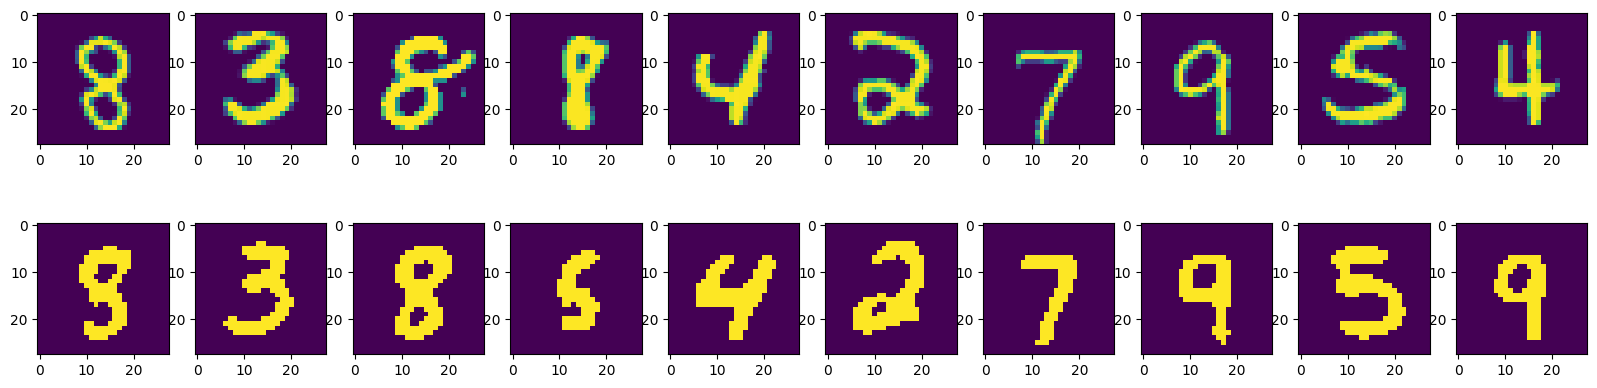

In [288]:
test_dataset = MNIST_Dataset(root_dir = "~/Anurag/MNIST",
                             set="Test",
                             transforms=transforms)
te_dataloader = DataLoader(test_dataset, batch_size=10,
                           shuffle=True, num_workers=0)

model = AutoEncoder(embed_dim=2)
checkpoint = torch.load(f"{model_out_path}/best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])

for i, batch in enumerate(te_dataloader):
    img, label = batch
    img = img.squeeze(1).reshape(-1, 28*28)
    
    imgs, re_imgs = generate_latents(model, img)
    re_imgs = np.asarray([[0 if i < 0.4 else 0.6 for i in row] for row in re_imgs])
    fig, ax = plt.subplots(2, 10, figsize=(20,5))
    #ax = ax.ravel()
    for i in range(10):
        ax[0, i].imshow(imgs[i].reshape(28, 28))
        ax[1, i].imshow(re_imgs[i].reshape(28, 28))
    break

Labels:10000, Data:10000


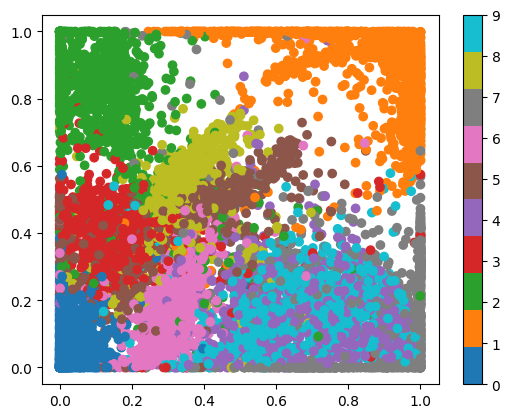

In [289]:
plot_latents(model, te_dataloader)

## VAE

In [261]:
##Variational AutoEncoders
class VarEncoder(nn.Module):
    """Encoder class for Auto-Encoder"""
    def __init__(self, embed_dim):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 512)
        self.mu = nn.Linear(512, embed_dim)
        self.sigma = nn.Linear(512, embed_dim)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.normal = torch.distributions.Normal(0, 1)

    def forward(self, x):
        """
        Takes input from MNIST dataset for toy example.
        Args:
            x is the input image in the shape of (batch, 28*28)

        Returns:
            An embedding vector tensor with shape (batch, self.embed_dim).
        """
        x = self.relu(self.linear1(x))
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))
        
        latents = mu + sigma*self.normal.sample(mu.shape)
        return latents, mu, sigma

class Decoder(nn.Module):
    """Decoder class for Auto-Encoder"""
    def __init__(self, embed_dim):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, 512)
        self.linear2 = nn.Linear(512, 28*28)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, embed):
        """
        Takes input the encoded vector.
        Args:
            embed is the input encoded embedding in the shape of (batch, self.embed_dim)

        Returns:
            A flattened tensor of the shape (batch, 28*28).
        """
        x = self.relu(self.linear1(embed))
        decoded = self.sig(self.linear2(x))
        return decoded
 
    
class VariationalAutoEncoder(nn.Module):
    """AutoEncoder class"""
    def __init__(self, embed_dim):
        super().__init__()
        self.encoder = VarEncoder(embed_dim)
        self.decoder = Decoder(embed_dim)

    def forward(self, x):
        embedding, mu, sigma = self.encoder(x)
        reconstructed = self.decoder(embedding)
        return embedding, reconstructed, mu, sigma
    
class KL_Divergence(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, mu, sigma):
        kl = 0.5*(sigma**2 + mu**2 - torch.log(sigma**2) - 1).sum()
        return kl

In [290]:
transforms = [pil_to_tensor]#, normalize]

train_dataset = MNIST_Dataset(root_dir="~/Anurag/MNIST", 
                              set='Train', 
                              transforms=transforms, filter_labels=[])

tr_dataloader = DataLoader(train_dataset, batch_size=128,
                           shuffle=True, num_workers=0)

val_dataset = MNIST_Dataset(root_dir="~/Anurag/MNIST", 
                              set='Valid', 
                              transforms=transforms, filter_labels=[])

va_dataloader = DataLoader(train_dataset, batch_size=128,
                           shuffle=True, num_workers=0)

vae = VariationalAutoEncoder(embed_dim=3)
kl_loss = KL_Divergence()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-05)
mse = nn.MSELoss(reduction='sum')
model_out_path = "~/Anurag/Projects/VAE/VAE/outputs/"
os.makedirs(model_out_path, exist_ok=True)

print(f"Train_Dataset Len:{len(train_dataset)} Valid Dataset Len:{len(val_dataset)}")

Train_Dataset Len:50000 Valid Dataset Len:10000


In [291]:
#Train
n_epochs=100
best_val_loss = 99999999
for epoch in range(n_epochs):
    vae.train()
    epoch_loss = 0
    
    for i, batch in enumerate(tr_dataloader):
        img, label = batch
        img = img.squeeze(1).reshape(-1, 28*28)

        optimizer.zero_grad()
        _, reconstructed_img, mu, sigma = vae(img)

        #Calculate loss
        mse_loss = mse(reconstructed_img, img)
        kl_div = kl_loss(mu, sigma)
        loss = mse_loss + kl_div

        loss.backward()

        # Adjust learning weights
        optimizer.step()
        epoch_loss += loss
        
    epoch_loss = epoch_loss / i
    val_loss = 0
    vae.eval()
    for i, batch in enumerate(va_dataloader):
        img, label = batch
        img = img.squeeze(1).reshape(-1, 28*28)
        
        _, reconstructed_img, mu, sigma = vae(img)
        
        #Calculate loss
        mse_loss = mse(reconstructed_img, img)
        kl_div = kl_loss(mu, sigma)
        loss = mse_loss + kl_div
        val_loss += loss
        
    val_loss = val_loss/i
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
                'epoch': epoch,
                'model_state_dict': vae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{model_out_path}/best_model.pth')
    if (epoch+1) % 1 == 0 or epoch == n_epochs-1:
        print(f"Epoch:{epoch+1}, Train_Loss:{epoch_loss}, Val_Loss:{val_loss}")

Epoch:1, Train_Loss:6100.4814453125, Val_Loss:5203.84326171875
Epoch:2, Train_Loss:5063.60205078125, Val_Loss:4976.94580078125
Epoch:3, Train_Loss:4917.11181640625, Val_Loss:4875.62158203125
Epoch:4, Train_Loss:4835.49462890625, Val_Loss:4803.609375
Epoch:5, Train_Loss:4771.8466796875, Val_Loss:4737.5087890625
Epoch:6, Train_Loss:4720.90771484375, Val_Loss:4696.03857421875
Epoch:7, Train_Loss:4677.357421875, Val_Loss:4658.87451171875
Epoch:8, Train_Loss:4642.63427734375, Val_Loss:4614.71337890625
Epoch:9, Train_Loss:4612.18603515625, Val_Loss:4596.16796875
Epoch:10, Train_Loss:4585.0732421875, Val_Loss:4568.10791015625
Epoch:11, Train_Loss:4562.93896484375, Val_Loss:4544.17626953125
Epoch:12, Train_Loss:4543.61083984375, Val_Loss:4533.634765625
Epoch:13, Train_Loss:4524.7822265625, Val_Loss:4517.19287109375
Epoch:14, Train_Loss:4508.40673828125, Val_Loss:4496.76904296875
Epoch:15, Train_Loss:4495.6337890625, Val_Loss:4477.65087890625
Epoch:16, Train_Loss:4480.611328125, Val_Loss:4477.1

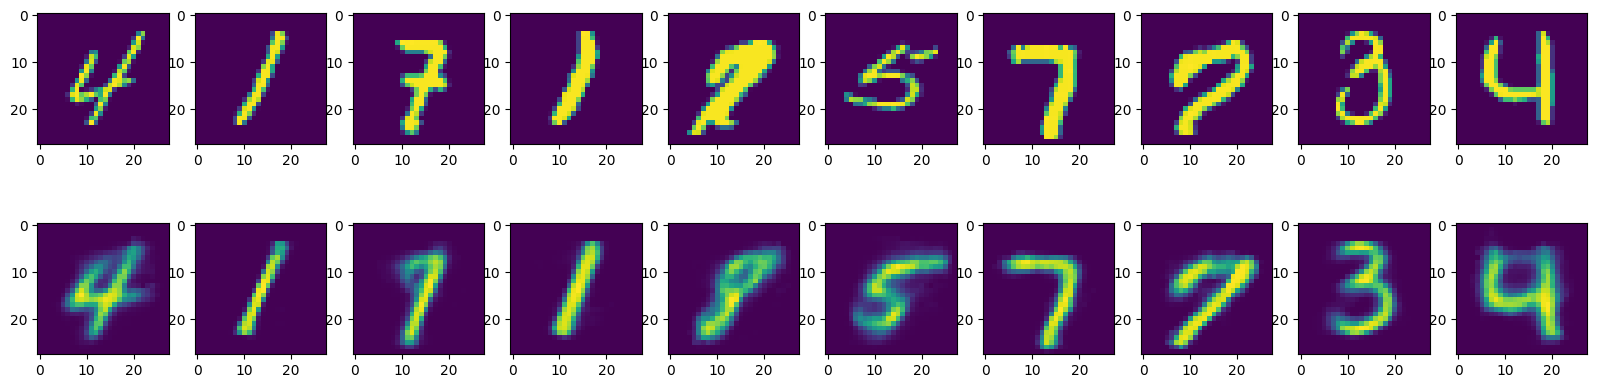

In [293]:
test_dataset = MNIST_Dataset(root_dir = "~/Anurag/MNIST",
                             set="Test",
                             transforms=transforms, filter_labels=[])
te_dataloader = DataLoader(test_dataset, batch_size=10,
                           shuffle=True, num_workers=0)

model = VariationalAutoEncoder(embed_dim=3)
checkpoint = torch.load(f"{model_out_path}/best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])

for i, batch in enumerate(tr_dataloader):
    img, label = batch
    img = img.squeeze(1).reshape(-1, 28*28)
    
    imgs, re_imgs = generate_latents(model, img, 'vae')
    #re_imgs = np.asarray([[0 if i < 0.5 else 1 for i in row] for row in re_imgs])
   
    fig, ax = plt.subplots(2, 10, figsize=(20,5))
    #ax = ax.ravel()
    for i in range(10):
        ax[0, i].imshow(imgs[i].reshape(28, 28))
        ax[1, i].imshow(re_imgs[i].reshape(28, 28))
    break

Labels:10000, Data:10000


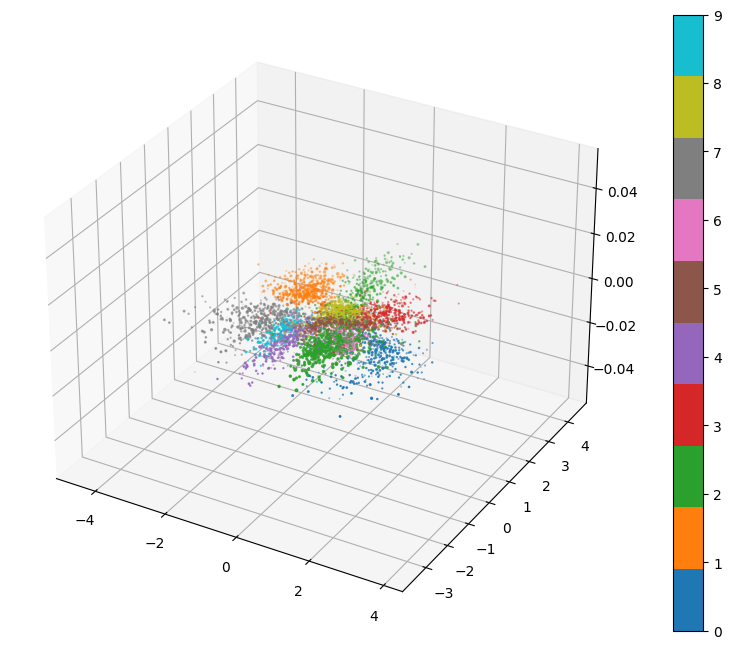

In [318]:
plot_latents(model, te_dataloader, mode='vae', fig_size=(12,8))